# Deep KNN method

This notebook aims at evaluating the **DKNN method**.

The method consists in performing K-Nearest-Neighbors in the feature space of a neural network trained on the in-distribution dataset.

Here, we focus on a ResNet18 network trained on MNIST, MNIST(0-4) and CIFAR-10. This model is challenged on
Fashion MNIST, MNIST (5-9), SVHN, LSUN, iSUN, and Texture OOD dataset.

**Reference**
[Out-of-Distribution Detection with Deep Nearest Neighbors](http://arxiv.org/abs/2204.06507), ICML 2022.

Some imports

In [1]:
%load_ext autoreload

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import matplotlib.pyplot as plt
import pandas as pd

from oodeel.methods import DKNN
from oodeel.eval.metrics import bench_metrics
from oodeel.datasets import OODDataset
from oodeel.models.training_funs import train_convnet_classifier_tf

Note that models are saved at *~/.oodeel/saved_models* and data is supposed to be found at *~/.oodeel/datasets* by default. Change the following cell for a custom path.

In [2]:

model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## MNIST (0-4) vs MNIST (5-9)

### Data and model loading

* in-distribution data: MNIST (0-4), 
* out-of-distribution data: MNIST (5-9)

/!\ We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD) data with `_out` to avoid confusion with OOD detection which is the name of the task, and is therefore used to denote core classes such as `OODDataset` and `OODModel`.

In [3]:
oods_train = OODDataset('mnist', split="train")
oods_test = OODDataset('mnist', split="test")

batch_size = 128
inc_labels = [0, 1, 2, 3, 4]
oods_train, _ = oods_train.assign_ood_labels_by_class(in_labels=inc_labels)
oods_in, oods_out = oods_test.assign_ood_labels_by_class(in_labels=inc_labels)


def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)
ds_in = oods_in.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)

Metal device set to: AMD Radeon Pro 5500M

systemMemory: 64.00 GB
maxCacheSize: 3.99 GB



In [4]:

model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4.h5")

try:
    model = tf.keras.models.load_model(model_path_mnist_04)
    
except OSError:
    train_config = {
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "batch_size": 128,
        "is_prepared": True,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier_tf(ds_train, **train_config) #ds_train is actually the train set of MNIST

### DKNN score

auroc       0.969201
fpr95tpr    0.134462
Name: mnist-0-4-vs-5-10, dtype: float64


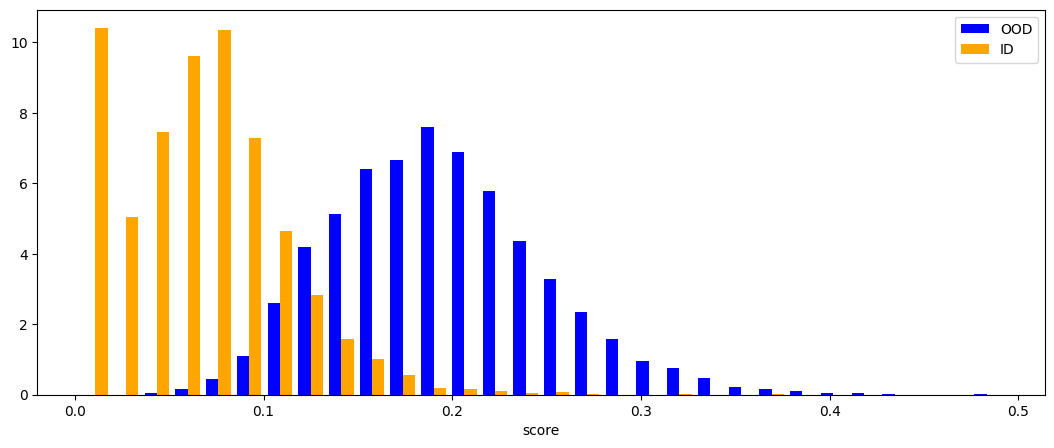

In [5]:
batch_size = 128

oodmodel = DKNN(nearest=50)
oodmodel.fit(model, ds_train)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr"], 
    )

metrics_first_vs_last = pd.Series(metrics, name='mnist-0-4-vs-5-10')
print(metrics_first_vs_last)

# plot hists / roc
plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("OOD", "ID"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

## MNIST vs Fashion MNIST


### Data and model loading
ID data: MNIST, OOD data: Fashion MNIST

In [6]:
oods_in = OODDataset('mnist', split="test")
oods_out = OODDataset('fashion_mnist', split="test")
oods_train = OODDataset('mnist', split="train")

def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))


batch_size = 128
ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)

In [7]:
model_path_mnist = os.path.join(model_path, "mnist_model.h5")

try:
    model = tf.keras.models.load_model(model_path_mnist)
    
except OSError:
    train_config = {
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "batch_size": 128,
        "optimizer": "adam",
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": oods_in.get_dataset() #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier_tf(oods_train.get_dataset(), **train_config) #

### DKNN score

auroc       0.998838
fpr95tpr    0.004000
Name: mnist-10-vs-fashion, dtype: float64


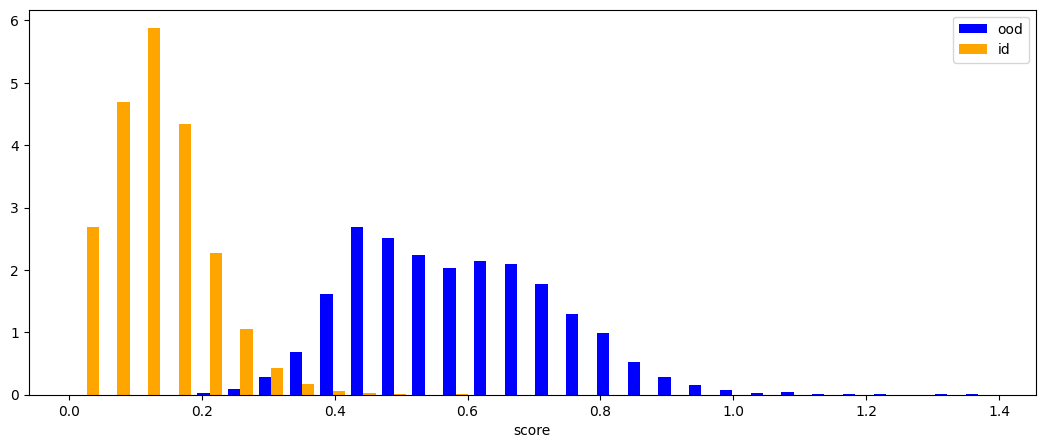

In [8]:
oodmodel = DKNN(nearest=50)
oodmodel.fit(model, ds_train)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr",], 
    )
metrics_fashion = pd.Series(metrics, name='mnist-10-vs-fashion')
print(metrics_fashion)

# plot hists / roc
plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

## CIFAR-10 vs [SVHN, LSUN, iSUN, Texture]

### ID Data and model loading

In [3]:
oods_in = OODDataset('cifar10', split="test", input_key="image", backend="torch", load_from_tensorflow_datasets=True)
oods_train = OODDataset('cifar10', split="train", input_key="image", backend="torch", load_from_tensorflow_datasets=True)

def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

batch_size = 128
ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)


In [10]:
from oodeel.models.training_funs import train_keras_app

model_path_cifar = os.path.join(model_path, "cifar10.h5")
try:
    model = tf.keras.models.load_model(model_path_cifar)
    
except OSError:
    train_config = {
        "input_shape": (32, 32, 3),
        "num_classes": 10,
        "batch_size": 128,
        "epochs": 200,
        "save_dir": model_path_cifar,
        "validation_data": oods_in.get_dataset() #ds_in is actually the test set of MNIST
    }

    model = train_keras_app(oods_train.get_dataset(), "resnet18", **train_config) 

In [4]:
model_path_cifar = os.path.join(model_path, "cifar_torch.pt")
import torch
model = torch.load(model_path_cifar) 



In [5]:
# ood dataset
oodmodel = DKNN(nearest=50, output_layers_id=['layer4'])
oodmodel.fit(model, ds_train)
scores_in = oodmodel.score(ds_in.take(100))


### OOD data: SVHN
ID data: CIFAR-10, OOD data: SVHN

auroc       0.99411
fpr95tpr    0.03050
Name: cifar-vs-svhn, dtype: float64


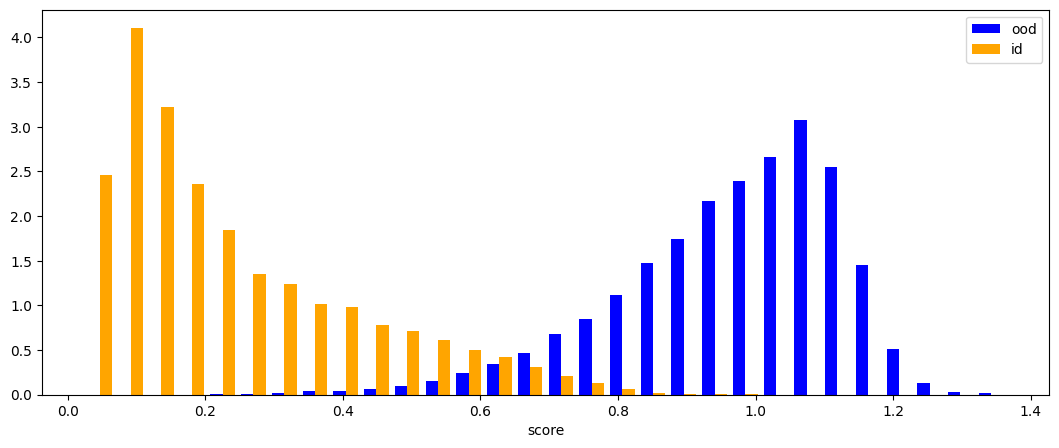

In [6]:

oods_out = OODDataset('svhn_cropped', split="test", input_key="image", backend="torch", load_from_tensorflow_datasets=True)
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)

scores_out = oodmodel.score(ds_out.take(100))

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_svhn = pd.Series(metrics, name='cifar-vs-svhn')
print(metrics_cifar_svhn)

# plot hists / roc
plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

### OOD data: LSUN
ID data: CIFAR-10, OOD data: LSUN

In [13]:

%autoreload 2

import tensorflow as tf
import os
"""
LSUN_root = os.path.join(data_path, "LSUN")
lsun_ds = tf.keras.utils.image_dataset_from_directory(
    LSUN_root,
    image_size=(32, 32),
    shuffle=False,
    batch_size=None
)
"""
load_kwargs = {"root": os.path.join(data_path, "LSUN_tvs")}
# ood dataset
ds_out = OODDataset("LSUN", split="test", backend="torch", load_kwargs=load_kwargs).prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
scores_out = oodmodel.score(ds_out.take(100))

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_lsun = pd.Series(metrics, name='cifar-vs-lsun')
print(metrics_cifar_lsun)

# plot hists / roc
plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

Error: /home/paul.novello/.oodeel/datasets/LSUN_tvs/test_lmdb: No such file or directory

### OOD data: iSUN
ID data: CIFAR-10, OOD data: iSUN

Found 8925 files belonging to 1 classes.
Feature name not found, assigning 'input_i' key to the i-th tensor and 'label' key to the last
auroc       0.928848
fpr95tpr    0.226400
Name: cifar-vs-isun, dtype: float64


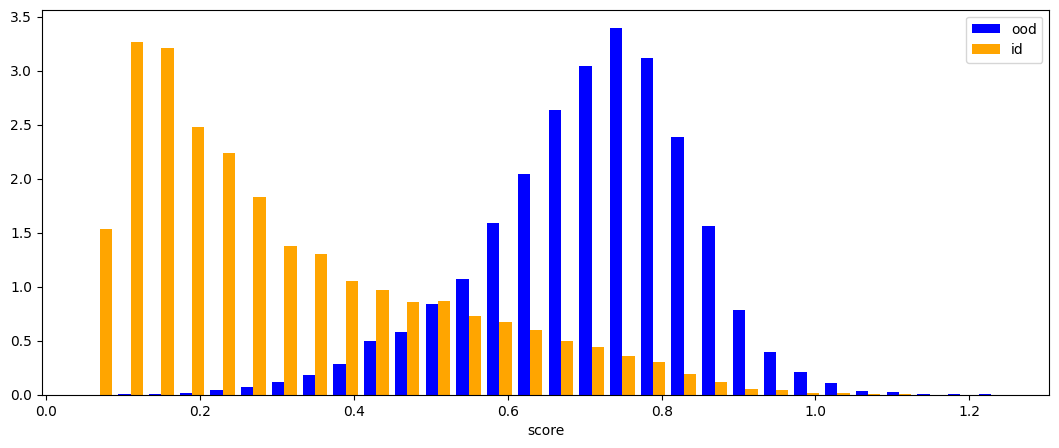

In [8]:
import tensorflow as tf
iSUN_root = os.path.join(data_path, "iSUN")
isun_ds = tf.keras.utils.image_dataset_from_directory(
    iSUN_root,
    image_size=(32, 32),
    shuffle=False,
    batch_size=None
)
# ood dataset
ds_out = OODDataset(isun_ds, backend="torch", load_from_tensorflow_datasets=True).prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
scores_out = oodmodel.score(ds_out)

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_isun = pd.Series(metrics, name='cifar-vs-isun')
print(metrics_cifar_isun)

# plot hists / roc
plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

### OOD data: Texture
ID data: CIFAR-10, OOD data: Texture

In [18]:
%autoreload 2

import tensorflow as tf
texture_root = os.path.join(data_path, "dtd")
texture_ds = tf.keras.utils.image_dataset_from_directory(
    texture_root,
    image_size=(32, 32),
    shuffle=False,
    batch_size=None,
)
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
imagesize = 32

transform_test = transforms.Compose([
    transforms.Resize((imagesize, imagesize)),
    transforms.CenterCrop(imagesize),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
    # transforms.Normalize([x/255.0 for x in [125.3, 123.0, 113.9]],
    #                     [x/255.0 for x in [63.0, 62.1, 66.7]]),
])

load_kwargs = {"root": os.path.join(data_path, "DTD"), "download": True}

texture_root = os.path.join(data_path, "dtd/images")
dataset = torchvision.datasets.ImageFolder(root=texture_root)     

# ood dataset
ds_out = OODDataset("DTD", split="test", backend="torch", load_kwargs=load_kwargs).prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)


Found 5640 files belonging to 3 classes.


  0%|          | 0/625239812 [00:00<?, ?it/s]

Failed download. Trying https -> http instead. Downloading http://thor.robots.ox.ac.uk/datasets/dtd/dtd-r1.0.1.tar.gz to /home/paul.novello/.oodeel/datasets/DTD/dtd/dtd-r1.0.1.tar.gz


  0%|          | 0/625239812 [00:00<?, ?it/s]

OSError: [Errno 122] Disk quota exceeded

In [17]:
for img in ds_out:
    print(img)

TypeError: Unexpected type <class 'tuple'>

In [ ]:

scores_out = oodmodel.score(ds_out)

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_texture = pd.Series(metrics, name='cifar-vs-texture')
print(metrics_cifar_texture)

# plot hists / roc
plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

## Results

In [10]:
pd.concat([metrics_first_vs_last, metrics_fashion, metrics_cifar_svhn, metrics_cifar_lsun, metrics_cifar_isun, metrics_cifar_texture], axis=1).T

NameError: name 'metrics_first_vs_last' is not defined

In [10]:
pd.concat([metrics_cifar_svhn, metrics_cifar_lsun, metrics_cifar_isun, metrics_cifar_texture], axis=1).T

,auroc,fpr95tpr
cifar-vs-svhn,0.994285,0.0277
cifar-vs-lsun,0.949663,0.1672
cifar-vs-isun,0.928848,0.2264
cifar-vs-texture,0.968243,0.1439
